In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_pickle("../data/processed/base_features.pkl")

In [2]:
df["date"] = pd.to_datetime(df["date"])  #converts the type ffrom str to datetime object

In [3]:
# sorting as pre Time order per athlete
df = df.sort_values(["athlete_id", "date"]).reset_index(drop=True)

In [4]:
# intentional grouping
load_features = ["daily_load_log", "acwr"]
physio_features = ["resting_hr", "hrv_z", "cns_drift_minutes"]
recovery_features = ["sleep_quality"]
history_features = ["past_injury", "days_since_injury"]

In [5]:
#Compute smoothed versions of daily_load over 7 and 14 days to capture trends rather than day-to-day spikes
df["load_7d"] = (
    df.groupby("athlete_id")["daily_load_log"]  #Keeps calculations per athlete
    .rolling(7, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

df["load_14d"] = (
    df.groupby("athlete_id")["daily_load_log"]
    .rolling(14, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

In [6]:
print(df.shape)

(3600, 17)


In [7]:
#Negative drop values indicate fatigue
df["hrv_7d_mean"] = (
    df.groupby("athlete_id")["hrv_z"]
    .rolling(7, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

df["hrv_drop"] = df["hrv_z"] - df["hrv_7d_mean"]

In [8]:
#sports-science credible
df["load_7d_std"] = (  #variability of training load
    df.groupby("athlete_id")["daily_load_log"]
    .rolling(7, min_periods=1)
    .std()
    .reset_index(level=0, drop=True)
)

df["training_monotony"] = df["load_7d"] / (df["load_7d_std"] + 1e-6) #how repetitive training is
df["training_strain"] = df["load_7d"] * df["training_monotony"] #overall stress on the athlete


In [ ]:
#Combines sleep and physiological recovery
'''It’s a single number that tries to summarize:
 How well the athlete slept
 How recovered their nervous system is (HRV)
 How stressed their body is (resting HR)
Instead of feeding 3 separate signals, you create one interpretable recovery index.'''

df["recovery_score"] = (
    0.5 * df["sleep_quality"] +
    0.3 * (df["hrv_z"] / df["hrv_z"].max()) -
    0.2 * (df["resting_hr"] / df["resting_hr"].max())
)

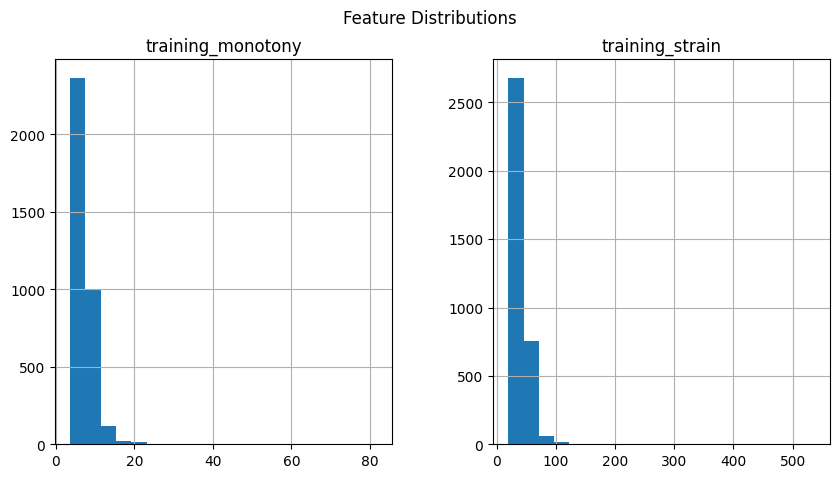

In [10]:
feature = [
    "training_monotony",
    "training_strain"
]
df[feature].hist(figsize=(10, 5), bins=20)
plt.suptitle("Feature Distributions")
plt.show()


In [11]:
df["training_monotony_log"] = np.log1p(df["training_monotony"])
df["training_strain_log"]   = np.log1p(df["training_strain"])

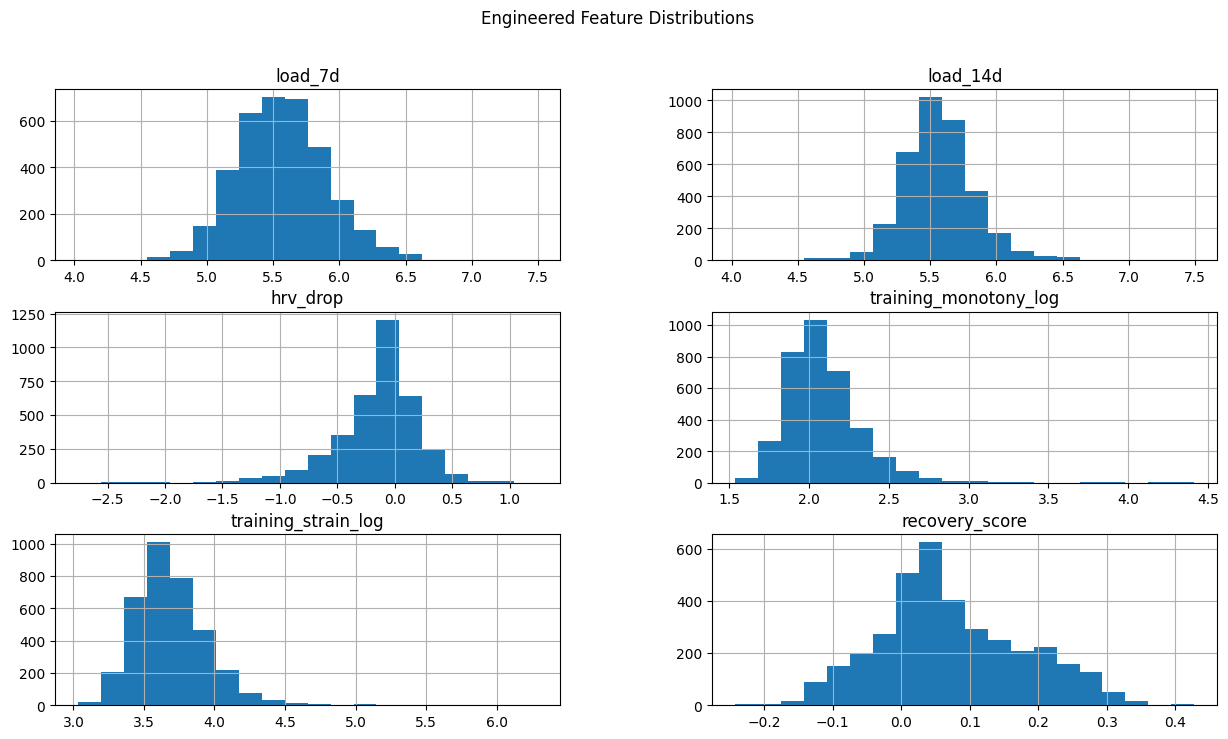

In [12]:
engineered_features = [
    "load_7d", "load_14d",
    "hrv_drop",
    "training_monotony_log",
    "training_strain_log",
    "recovery_score"
]

df[engineered_features].hist(figsize=(15, 8), bins=20)
plt.suptitle("Engineered Feature Distributions")
plt.show()

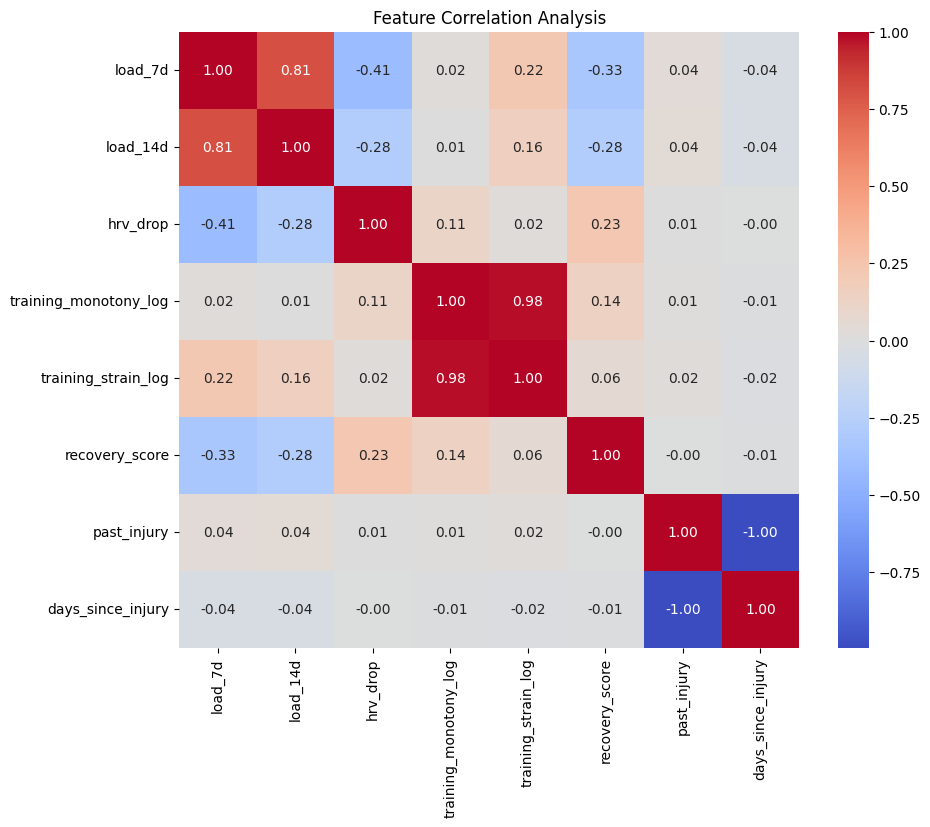

In [13]:
#Temporary proxy until final label
corr_cols = engineered_features + history_features

plt.figure(figsize=(10,8))
sns.heatmap(
    df[corr_cols].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Feature Correlation Analysis")
plt.show()

In [14]:
df.shape

(3600, 25)

In [15]:
df.to_csv("../data/processed/athlete_features_engineered.csv", index=False)